In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pickle.load(open('../Data/unimputed_inr_patient_data.pkl', 'rb'), encoding='latin1')

In [3]:
data[0]

{'nsaid_times': [],
 'transfusion_times': [array([], dtype=float64), array([], dtype=float64)],
 'obs_times': array([120.]),
 'event_time': 650.0,
 'sepsis': 0,
 'chronic_names': ['liver_disease', 'sickle_cell'],
 'demographic': array([32.]),
 'anticoagulant_times': [],
 'marker_name': 'inr',
 'aspirin_times': [],
 'chronic': array([0., 0.]),
 'transfusion_names': ['transfuse_plasma', 'transfuse_platelets'],
 'obs_y': array([0.9]),
 'nsaid_names': ['acetaminophen_dose',
  'celecoxib_dose',
  'diclofenac_dose',
  'ibuprofen_dose',
  'indomethacin_dose',
  'ketorolac_dose',
  'meloxicam_dose',
  'naproxen_dose'],
 'excess_alcohol': 0.0,
 'inr_orgdf': 0,
 'anticoagulant_names': ['warfarin_dose',
  'heparin_dose',
  'dabigatran_dose',
  'edoxaban_dose',
  'rivaroxaban_dose',
  'apixaban_dose',
  'enoxaparin_dose',
  'dalteparin_dose',
  'fondaparinux_dose'],
 'id': 8,
 'demographic_names': ['age']}

### Some notes on the data
* 4 types of treatments: nsaid (8), transfusion (2), anticoagulant (9), aspirin (1)
* 2 types of chronic conditions: liver disease, sickle cell
* 1 demographic information: age (integer)
* 2 other informations: excess alcohol (binary), sepsis (binary)  

### Things to determine
* Cutoff point for number of observations
* How to determine the time interval? Since we can deal with missing value relatively well, we want to make the interval as fine grain as possible to maximize data usage. Average interval between observations and treatments are all around 1000. 95% of intervals for obs and aspirin are larger than 900-1000; 95% of intervals of anticoagulant and nsaid are larger than 400-500. 
* After specifying the interval, what if there are multiple values in that interval? Take average?
* A small number of patients have received treatments befort the first observation. Should we consider the first observation as the starting point for each time series and simply disrecard those treatments and let the initial state value capture their effects?

Patients with obs times >= 5: 2524.0
Patients with obs times >= 10: 651.0
Patients with obs times >= 15: 212.0
Patients with obs times >= 20: 95.0


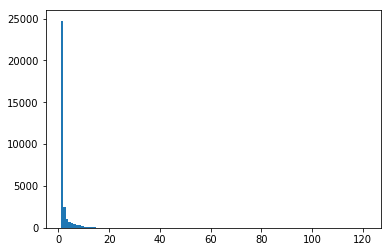

In [4]:
data_5 = []
data_7 = []
data_10 = []
num_obs = []
for d in data:
    num = d['obs_times'].shape[0]
    num_obs.append(num)
    if num >= 5:
        data_5.append(d)
    if num >= 7:
        data_7.append(d)
    if num >= 10:
        data_10.append(d)

max_num_obs = max(num_obs)
num_obs_hist = plt.hist(num_obs, bins = max_num_obs, range=(1, max_num_obs))[0]

print('Patients with obs times >= 5: {}'.format(np.sum(num_obs_hist[4:])))
print('Patients with obs times >= 10: {}'.format(np.sum(num_obs_hist[9:])))
print('Patients with obs times >= 15: {}'.format(np.sum(num_obs_hist[14:])))
print('Patients with obs times >= 20: {}'.format(np.sum(num_obs_hist[19:])))

In [5]:
data = data_5

### Observational time

In [6]:
def time_span(data, name):
    time_span = []
    for d in data:
        time_span.append(d['obs_times'][-1] - d['obs_times'][0])
    return time_span 
        
def avg_interval(data, name):
    avg_interval = []
    for d in data:
        if type(d[name+'_times']) is list and len(d[name+'_times']) < 2:
            continue
        diff = np.subtract(d[name+'_times'], np.roll(d[name+'_times'], shift=1))
        diff = np.delete(diff, 0)
        avg_interval.append(np.average(diff))
    return avg_interval
    
def avg_times_of(data, name):
    num = []
    for d in data:
        num.append(d[name + '_times'].shape[0])
    print('avg number of ' + name + ': {}'.format(np.average(num)))

In [7]:
print('avg overall time span of obs: {}'.format(np.mean(time_span(data, 'obs'))))
print('avg interval between obs: {}'.format(np.mean(avg_interval(data, 'obs'))))
avg_times_of(data, 'obs')

avg overall time span of obs: 11501.120839936608
avg interval between obs: 1496.3954056598004
avg number of obs: 8.707606973058637


In [8]:
print('95% has avg interval between obs larger than: {}'.format(np.percentile(avg_interval(data, 'obs'), 5)))

95% has avg interval between obs larger than: 909.5339285714285


### INR values

(array([6400., 5685., 4069., 2781., 1157.,  766.,  417.,  205.,  143.,
          81.,   72.,   34.,   31.,   43.,   23.,   29.,   10.,   13.,
           9.,   10.]),
 array([ 0.8 ,  1.36,  1.92,  2.48,  3.04,  3.6 ,  4.16,  4.72,  5.28,
         5.84,  6.4 ,  6.96,  7.52,  8.08,  8.64,  9.2 ,  9.76, 10.32,
        10.88, 11.44, 12.  ]),
 <a list of 20 Patch objects>)

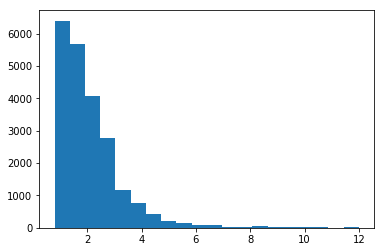

In [9]:
inr = []
for d in data:
    inr.append(d['obs_y'])
inr_arr = np.concatenate(inr)
inr_hist = plt.hist(inr_arr, bins = 20)
inr_hist

### Age

(array([ 22.,  63.,  72., 118., 228., 286., 436., 521., 563., 215.]),
 array([17. , 25.1, 33.2, 41.3, 49.4, 57.5, 65.6, 73.7, 81.8, 89.9, 98. ]),
 <a list of 10 Patch objects>)

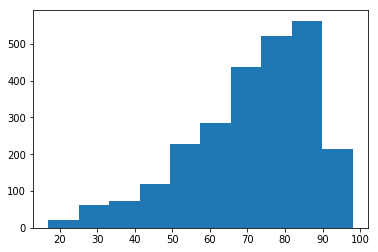

In [10]:
age = []
for d in data:
    age.append(d['demographic'])
age_arr = np.concatenate(age)
age_hist = plt.hist(age_arr, bins = 10)
age_hist

### Chronic

In [11]:
liver = np.zeros(len(data))
sickle = np.zeros(len(data))
for i, d in enumerate(data):
    liver[i] = d['chronic'][0]
    sickle[i] = d['chronic'][1]
liver_num = np.unique(liver, return_counts=True)[1]
sickle_num = np.unique(sickle, return_counts=True)[1]
print('No liver disease: {}; with liver disease: {}'.format(liver_num[0], liver_num[1]))
print('No sickle cell: {}; with sickle cell: {}'.format(sickle_num[0], sickle_num[1]))

No liver disease: 2318; with liver disease: 206
No sickle cell: 2510; with sickle cell: 14


In [12]:
inr_liver_disease = []
inr_no_liver_disease = []
for i in np.where(liver == 0)[0]:
    inr_no_liver_disease.append(data[i]['obs_y'])
for i in np.where(liver == 1)[0]:
    inr_liver_disease.append(data[i]['obs_y'])
inr_liver_disease = np.concatenate(inr_liver_disease)
inr_no_liver_disease = np.concatenate(inr_no_liver_disease)

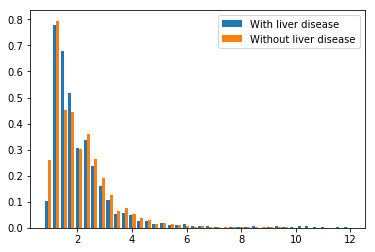

In [13]:
plt.hist([inr_liver_disease, inr_no_liver_disease], bins=40, density=True, label=['With liver disease', 'Without liver disease'])
plt.legend()

In [14]:
inr_sickle = []
inr_no_sickle = []
for i in np.where(sickle == 0)[0]:
    inr_no_sickle.append(data[i]['obs_y'])
for i in np.where(sickle == 1)[0]:
    inr_sickle.append(data[i]['obs_y'])
inr_sickle = np.concatenate(inr_sickle)
inr_no_sickle = np.concatenate(inr_no_sickle)

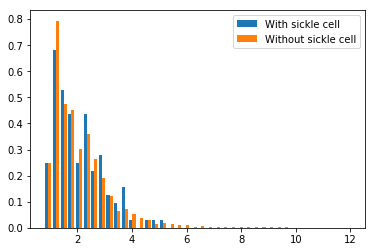

In [15]:
plt.hist([inr_sickle, inr_no_sickle], bins=40, density=True, label=['With sickle cell', 'Without sickle cell'])
plt.legend()

### Treatments

In [16]:
def num_treatment(treatment_name):
    num_t = []
    for d in data:
        num_t.append(len(d[treatment_name + '_times']))

    num_t = np.array(num_t)
    print('Number of times ' + treatment_name +  ' is given')
    unique = np.unique(num_t, return_counts=True)
    print('Unique values : {}'.format(unique[0]))
    print('Counts for unique values : {}'.format(unique[1]))

In [17]:
num_treatment('nsaid')
num_treatment('anticoagulant')
num_treatment('aspirin')

Number of times nsaid is given
Unique values : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  37  41
  47  48  68  72  74 109 131]
Counts for unique values : [1310  323  190  146  108   75   49   68   46   31   16   15   24   18
   12   13   14    9    6    6    4    3    6    5    2    1    2    2
    4    1    3    1    1    1    1    1    1    1    1    1    1    1
    1]
Number of times anticoagulant is given
Unique values : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  48  49  50  51  52  53  54
  56  57  59  61  63  65  68  70  72  73  74  75  78  79  81  83  85  89
 103 105 110 116 122 143 163 166 224 227]
Counts for unique values : [170  63 115 175 199 177 149 126  79  88  98  60  89  71  73  74  80  67
  53  57  41  37  49  29  20  26  11  26 

In [18]:
print('avg interval between nsaid: {}'.format(np.mean(avg_interval(data, 'nsaid'))))
print('avg interval between anticoagulant: {}'.format(np.mean(avg_interval(data, 'anticoagulant'))))
print('avg interval between aspirin: {}'.format(np.mean(avg_interval(data, 'aspirin'))))

avg interval between nsaid: 2136.203516816744
avg interval between anticoagulant: 1136.4531503337819
avg interval between aspirin: 1613.144137578135


In [19]:
print('95% has avg interval between nsaid larger than: {}'.format(np.percentile(avg_interval(data, 'nsaid'), 5)))
print('95% has avg interval between anticoagulant larger than: {}'.format(np.percentile(avg_interval(data, 'anticoagulant'), 5)))
print('95% has avg interval between aspirin larger than: {}'.format(np.percentile(avg_interval(data, 'aspirin'), 5)))

95% has avg interval between nsaid larger than: 408.0
95% has avg interval between anticoagulant larger than: 446.525
95% has avg interval between aspirin larger than: 1237.1136363636363


In [20]:
treatments = ['nsaid', 'anticoagulant', 'aspirin']

def num_treatments_before_first_obs(name):
    num_t = []
    for d in data:
        first_obs = d['obs_times'][0]
        num_t.append(np.where(np.array(d[name+'_times']) < first_obs)[0].shape[0])
    num_t = np.array(num_t)
    return np.unique(num_t, return_counts=True)

In [21]:
num_treatments_before_first_obs('anticoagulant')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 21, 22, 23, 24, 46]),
 array([2196,  121,  114,   29,   14,    7,    5,    6,    6,    3,    2,
           1,    3,    2,    2,    1,    3,    1,    2,    1,    1,    2,
           1,    1]))

In [22]:
a = np.array([1, 2, 3, 4])
np.where(a < 3)[0].shape[0]

2

### Sepsis

In [23]:
sepsis = []
for d in data:
    sepsis.append(d['sepsis'])
sepsis = np.array(sepsis)
sepsis_unique = np.unique(sepsis, return_counts=True)
print('Sepsis: {}'.format(sepsis_unique[1][0]))
print('No Sepsis: {}'.format(sepsis_unique[1][1]))

Sepsis: 1720
No Sepsis: 804


In [32]:
def plot(n):
    times = data[n]['obs_times']
    inr = data[n]['obs_y']
    fig = plt.figure()
    plt.plot(times, inr, '.', label = 'observed inr')
    names = ['nsaid', 'anticoagulant', 'aspirin']
    colors = ['r', 'g', 'c']
    for i, name in enumerate(names):
        treatment = data[n][name + '_times']
        for t in treatment:
            plt.axvline(x=t, linestyle=':', color=colors[i])
    tf = np.concatenate(data[n]['transfusion_times'])
    for t in tf:
        plt.axvline(x=t, linestyle=':', color='y')
    plt.legend()
    fig.set_figheight(8)
    fig.set_figwidth(15)
    plt.show()

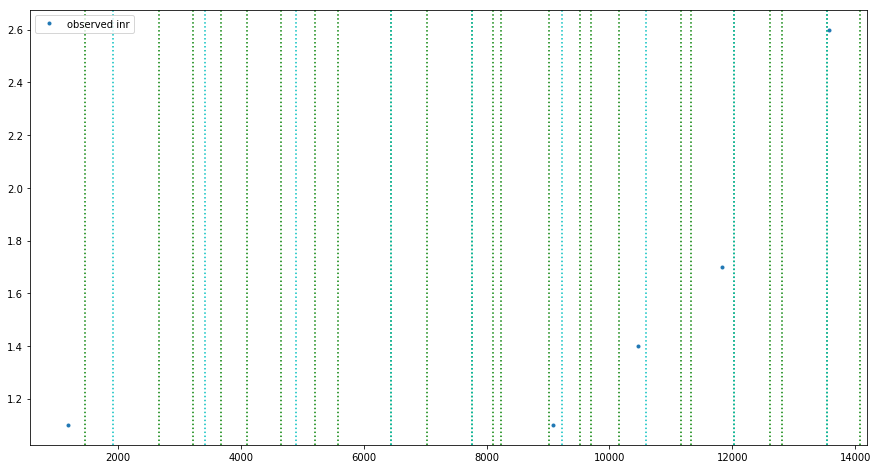

In [50]:
i = 500
plot(i)

In [51]:
data[i]['obs_times']

array([ 1189.,  9080., 10466., 11839., 13578.])

In [52]:
data[i]['obs_y']

array([1.1, 1.1, 1.4, 1.7, 2.6])

In [53]:
data[i]['anticoagulant_times']

[1456.0,
 2660.0,
 3215.0,
 3684.0,
 4106.0,
 4652.0,
 5199.0,
 5573.0,
 6449.0,
 7036.0,
 7762.0,
 8107.0,
 8233.0,
 9019.0,
 9517.0,
 9708.0,
 10161.0,
 11159.0,
 11327.0,
 12035.0,
 12614.0,
 12811.0,
 13539.0,
 14088.0]

In [58]:
data[i]['demographic']

array([84.])